# Exoplanet classification with a Convolutional Neural Network

## Background
In this exercise we will use light transit curves of NASA's Kepler mission to classify exoplanets. The dataset includes time profiles of the flux-density of stars observed by the Kepler telescope. While stars without exoplanets show a regular, stable flux-density, the flux-density of stars with exoplanets show characteristic dips in brightness, as an exoplanet passes in front of the star and hence blocks a proportion of the total brightness coming from the star. The animation below illustrates this effect.

<div style="text-align: center">
    <!--<img src="../data/supplementary_data/Exoplanet_Animation_Transit_Light_Curve_appletv.gif">-->
    <p>Source: <a href="https://science.nasa.gov/resource/transit-light-curve/">NASA</a></p>
</div>

## Aim of the exercise
The aim of this exercise is to classify light transit curves of stars observed by the Kepler telescope into two classes: stars with exoplanets and stars without exoplanets. We will use labelled data of light-transit curves of stars, with and without exoplanets, to train a Convolutional Neural Network (CNN) to classify the light-transit curves.

# A: Data Analysis
First we create a class, which we will use to load, explore and preprocess the data:

In [108]:
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats
from dataclasses import dataclass
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import scienceplots
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
from tensorflow.keras.models import Sequential
import copy

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
plt.style.use(['science', 'grid'])

# Global variables
no_vals: list[str] = ['LABEL', 'TYPE', 'FLAG']

@dataclass
class KeplerCurves:
    """
    Data class that contains the light transit curves.
    """
    data: pd.DataFrame | None = None
    data_pca: pd.DataFrame | None = None
    data_augmented: pd.DataFrame | None = None
    history = None
    model: Sequential | None = None
    report = None
    predictions = None
    predicted_labels = None
    label_test = None

    # Data IO
    def from_csv(self, train_path: str, test_path: str | None = None) -> None:
        """
        Load the data from csv files. The data should have the following columns:
        - LABEL: 2 if the star has an exoplanet, 1 otherwise. This column will be converted to a binary unit (to 0 and 1).
        - FLUX: The flux-density of the star.
        """
        self.data = pd.read_csv(train_path)
        self.data['LABEL'] -= 1  # Normalize the label to 0 and 1
        self.data['TYPE'] = 'TRAIN'  
        
        if test_path:
            test_data = pd.read_csv(test_path)
            test_data['LABEL'] -= 1
            test_data['TYPE'] = 'TEST'
            self.data = pd.concat([self.data, test_data], ignore_index=True)
            
            
        # Create an ID column to identify the stars
        self.data['ID'] = self.data.index        
                
        # Create a flag column for filtered entries
        self.data['FLAG'] = False
        
        # Reorder the columns
        self.data.insert(0, 'ID', self.data.pop('ID'))
        self.data.insert(1, 'TYPE', self.data.pop('TYPE'))
        self.data.insert(2, 'LABEL', self.data.pop('LABEL'))
        self.data.insert(3, 'FLAG', self.data.pop('FLAG'))
        
        self.data = self.data.set_index('ID', inplace=False)
        
        # Create a dataframe of star-id's to keep track of data augmentation
        # Col 'ID' represents the original star-id, Col '<augmentation-type>' includes a new ID indicating the applied augmentation or None if no augmentation was applied
        self.data_augmented = pd.DataFrame(index=self.data.index)
        
        assert(len(self.data['LABEL'].unique()) == 2)
        

    def generate_test_data(self, n_samples: int) -> None:
        """
        Generate test data from the training data.
        """
        test_ids = np.random.choice(self.data['ID'], n_samples, replace=False)
        self.data.loc[:, 'TYPE'] = 'TRAIN'
        self.data.loc[test_ids, 'TYPE'] = 'TEST'
    
    def plot_light_curve(self, idx: tuple) -> None:
        """
        Plot the light curve of a star.
        """
        number_of_plots = len(idx)
        fig, ax = plt.subplots(number_of_plots, 1, figsize=(10, number_of_plots * 5))
        
        for i, index in enumerate(idx):
            star = self.data.loc[index]
            label = ' - Exoplanet' if star['LABEL'] == 1 else ' - No Exoplanet'
            ax[i].plot(star[3:])
            ax[i].set_title(f"Star {index}" + label)
            ax[i].set_xlabel("Time")
            ax[i].set_ylabel("Flux Density")
            ax[i].set_xticks([])

        plt.show()

    # Data pre-processing  
    def filter_nan(self) -> None:
        """
        Filter NaN-data from the dataset.
        """
        rows_before: int = len(self.data)
        
        self.data.dropna(how='any', inplace=True)
        
        rows_after: int = len(self.data)
        
        print(f"NaN-data filtered: \t {rows_before - rows_after} rows removed.")
        

    def scaler(self, model: str = 'standard') -> pd.DataFrame | None:
        """
        Normalize the dataset using the Z-score (computed on the training data) and filter outliers.
        
        :param model: The model to use for scaling. Either 'standard' or 'minmax'.
        """
        
        scaler = StandardScaler() if model == 'standard' else MinMaxScaler()
        
        # Apply the log-transformation
        self.data.iloc[:, 3:] = scaler.fit_transform(self.data.drop(columns=no_vals).T).T
    
    def interpolate(self, threshold: float = 3.) -> None:
        """
        Interpolate the outliers in the dataset.
    
        :param threshold: The threshold for the z-score.
        :return: None
        """
        outliers: pd.DataFrame = np.abs(stats.zscore(self.data.drop(columns=no_vals), axis=1)) > threshold
    
        # Moving average for outliers
        self.data.iloc[:, 3:] = self.data.drop(columns=no_vals).mask(outliers).interpolate(method='linear', axis=1)
    
        # If any NaN values remain after interpolation, fill them using forward-fill and then backward-fill
        if self.data.isnull().values.any():
            self.data.iloc[:, 3:] = self.data.drop(columns=no_vals).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)
    
        # Ensure no NaN values remain
        if self.data.isnull().values.any():
            print("Warning: There are still NaN values present in the data after interpolation.")

        
        

    def pca(self, n_components: int | None = None, variance_threshold: float = 1.) -> np.ndarray:
        """
        Apply PCA to the dataset.
    
        :param n_components: Number of components to keep.
        :param variance_threshold: The threshold of the variance to keep.
        :return: The cumulative variance of the principal components.
        """
        pca = PCA()
        pca.fit(self.data[(self.data['TYPE'] == 'TRAIN') & (self.data['FLAG'] == False)].drop(columns=no_vals))
    
        explained_variances = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variances)
    
        if n_components is None:
            n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
            print(f"Number of components to explain {variance_threshold * 100}% of the variance: {n_components}")
    
        pca = PCA(n_components=n_components)
        pca.fit(self.data[self.data['TYPE'] == 'TRAIN'].drop(columns=no_vals))
    
        pca_transformed_data = pca.transform(self.data.drop(columns=no_vals))
    
        # Create a new DataFrame with the PCA components and the non-PCA columns
        pca_columns = [f'PC{i+1}' for i in range(pca_transformed_data.shape[1])]
        self.data_pca = pd.DataFrame(pca_transformed_data, columns=pca_columns, index=self.data.index)
    
        # Add back the non-PCA columns
        for col in no_vals:
            self.data_pca = self.data_pca.assign(**{col: self.data[col]})
    
        return cumulative_variance
    
        
    def gaussian_filter(self, ids: list[int], sigma: float = 1.0) -> None:
        """
        Apply a Gaussian filter to the dataset.
        
        :param ids: List of star-ids to apply the Gaussian filter to.
        :param sigma: The standard deviation of the Gaussian filter.
        """
        
        print("Input indices: ", ids)
        
        data_gauss = self.data.loc[ids]
        
        new_indices = self.data.index.max() + np.arange(len(ids)) + 1
        data_gauss.index = new_indices
        
        data_gauss.iloc[:, 3:] = data_gauss.drop(columns=no_vals).apply(lambda x: gaussian_filter(x, sigma))
        
        print(f"Gaussian filter applied to stars: {data_gauss.index}")
        
        self.data = pd.concat([self.data, data_gauss])
        
        for original_idx, new_idx in zip(ids, new_indices):
            self.data_augmented.at[original_idx, 'GAUSSIAN_FILTER'] = new_idx
        
        
    def gaussian_noise(self, ids: list[int], sigma: float = 1.0) -> None:
        """
        Apply Gaussian noise to the dataset.
        
        :param ids: List of star-ids to apply the Gaussian noise to.
        :param sigma: The standard deviation of the Gaussian noise.
        """
        
        print("Input indices: ", ids)
        
        data_noise = self.data.loc[ids] 
        
        new_indices = self.data.index.max() + np.arange(len(ids)) + 1
        data_noise.index = new_indices
        
        data_noise.iloc[:, 3:] = data_noise.drop(columns=no_vals).apply(lambda x: x + np.random.normal(0, sigma, x.shape))
        
        print(f"Gaussian noise applied to stars: {data_noise.index}")
        
        self.data = pd.concat([self.data, data_noise])
        
        for original_idx, new_idx in zip(ids, new_indices):
            self.data_augmented.at[original_idx, 'GAUSSIAN_NOISE'] = new_idx
        
        
    def time_shift_augmentation(self, ids: list[int], shift: str | int = 'random') -> None:
        """
        Apply time-shift augmentation to the dataset.
        
        :param ids: List of star-ids to apply the time-shift augmentation to.
        :param shift: The number of time steps to shift the light curve. If 'random', the shift is randomly chosen.
        """
        
        data_shift = self.data.loc[ids]
                
        new_indices = self.data.index.max() + np.arange(len(ids)) + 1
        data_shift.index = new_indices
        
        data_shift.iloc[:, 3:] = data_shift.drop(columns=no_vals).apply(lambda x: np.roll(x, np.random.randint(0, len(x)) if shift == 'random' else shift))
        
        print(f"Time-shift augmentation applied to stars: {data_shift.index}")
        
        self.data = pd.concat([self.data, data_shift])
        for original_idx, new_idx in zip(ids, new_indices):
            self.data_augmented.at[original_idx, 'TIME_SHIFT'] = new_idx
        
    def time_flip(self, ids: list[int]) -> None:
        """
        Apply time-flip augmentation to the dataset.
        
        :param ids: List of star-ids to apply the time-flip augmentation to.
        :return: None
        """
        
        print("Input indices: ", ids)
        
        data_flip = self.data.loc[ids]
        
        new_indices = self.data.index.max() + np.arange(len(ids)) + 1
        data_flip.index = new_indices
        
        data_flip.iloc[:, 3:] = data_flip.iloc[:, 3:].apply(lambda x: x[::-1], axis=1)
        
        print(f"Time-flip augmentation applied to stars: {data_flip.index}")
        
        self.data = pd.concat([self.data, data_flip])
        for original_idx, new_idx in zip(ids, new_indices):
            self.data_augmented.at[original_idx, 'TIME_FLIP'] = new_idx
        
    def compare_augmented(self, idx: int, aug_type: str = 'TIME_FLIP') -> None:
        """
        Compare the original star with its augmented versions.
        
        :param idx: (int) The index of the star.
        :param aug_type: (str) The type of the augmentation.'TIME_SHIFT', 'TIME_FLIP', 'GAUSSIAN_NOISE', 'GAUSSIAN_FILTER'.
        :return: None
        """
        
        aug_copy: int = self.data_augmented.loc[idx][aug_type]
        
        print(f"Original star: {idx}")
        print(f"Augmented star: {aug_copy}")
        
        fig, ax = plt.subplots(2, 1, figsize=(10, 8))
        ax[0].plot(self.data.loc[idx][3:].to_numpy(), label='Original', linestyle='--', linewidth=0.5, alpha=0.8, color='blue')
        ax[0].plot(self.data.loc[int(aug_copy)][3:].to_numpy(), label='Augmented', linestyle='-.', linewidth=0.5, alpha=0.8, color='red')
        ax[0].set_title(f"Star {idx} - Augmented with {aug_type}")
        ax[0].set_xlabel("Time")
        ax[0].set_ylabel("Flux Density")
        ax[0].legend()
        
        # Plot the difference
        ax[1].plot(self.data.loc[idx][3:].to_numpy() - self.data.loc[aug_copy][3:].to_numpy(), label='Difference', linestyle='-', linewidth=0.5, alpha=0.8, color='green')
        ax[1].set_title(f"Star {idx} - Difference")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Flux Density")
        ax[1].legend()
        
        plt.show()
        
    def train_model(self, optimizer: str = 'adam', loss: str = 'binary_crossentropy', metrics: list[str] | None = None, which: str = 'norm', use_augmented: bool = True) -> None:
        """
        Compile the model.
        
        :param optimizer: The optimizer to use.
        :param loss: The loss function to use.
        :param metrics: The metrics to use.
        :param which: The data to use for training. 'pca' or 'norm'.
        :param use_augmented: Use the augmented data.
        :return: None
        """
        if not use_augmented:
            augmented_indices: list[int] = Kepler.data_augmented[Kepler.data_augmented.iloc[:, 1:].notna().any(axis=1)].to_numpy().astype('int').flatten()
        else:
            augmented_indices: list[int] = []
        
        if metrics is None:
            metrics = ['accuracy']
            
        if self.model is None:
            raise ValueError("No model defined.")
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        
        
        # Reshape the data to fit the model
        if which == 'pca':
            number_features: int = Kepler.data_pca.drop(columns=no_vals).shape[1]
            data_train = self.data_pca[(self.data_pca['TYPE'] == 'TRAIN') & (~self.data_pca.index.isin(augmented_indices))].drop(columns=no_vals).values.reshape(-1, number_features, 1)
            label_train = self.data_pca[(self.data_pca['TYPE'] == 'TRAIN') & (~self.data_pca.index.isin(augmented_indices))].loc[:, ['LABEL']].values        
        elif which == 'norm':
            number_features: int = Kepler.data.drop(columns=no_vals).shape[1]
            data_train = self.data[(self.data['TYPE'] == 'TRAIN') & (~self.data.index.isin(augmented_indices))].drop(columns=no_vals).values.reshape(-1, number_features, 1)
            label_train = self.data[(self.data['TYPE'] == 'TRAIN') & (~self.data.index.isin(augmented_indices))].loc[:, ['LABEL']].values
        else:
            raise ValueError("Invalid argument for 'which'. Select 'pca' or 'norm'.")
        
        assert(data_train.shape[0] == label_train.shape[0])
        
        # Train the model
        self.history = self.model.fit(data_train, label_train, epochs=10, validation_split=0.2)
        
        
    def define_model(self, model: Sequential, get_summary: bool = False) -> None:
        """
        Define the model.
        
        :param get_summary: Print the model summary.
        :param model: The model to define.
        :return: None
        """
        self.model = model
        
        if get_summary:
            model.summary()
        
    def plot_loss(self) -> None:
        """
        Plot the loss of the model.
        """
        
        if self.history is None:
            print("No history available.")
            return
        
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax.plot(self.history.history['loss'], label='Training Loss')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        plt.show()
        
    def test_model(self, which: str = 'norm') -> dict:
            """
            Test the model on the test data and return performance metrics.
            
            :which: (str) 'pca' or 'norm' to test the model on the PCA or the normalized data.
            :return: A dictionary containing accuracy, precision, recall, and F1-score.
            """
            if self.model is None:
                raise ValueError("No model defined.")
    
                        
            if which == 'pca':
                number_features: int = Kepler.data_pca.drop(columns=no_vals).shape[1]
                data_test = self.data_pca[self.data_pca['TYPE'] == 'TEST'].drop(columns=no_vals).values.reshape(-1, number_features, 1)
                self.label_test = self.data_pca[self.data_pca['TYPE'] == 'TEST']['LABEL'].values
            elif which == 'norm':
                number_features: int = Kepler.data.drop(columns=no_vals).shape[1]
                data_test = self.data[self.data['TYPE'] == 'TEST'].drop(columns=no_vals).values.reshape(-1, number_features, 1)
                self.label_test = self.data[self.data['TYPE'] == 'TEST']['LABEL'].values
            else:
                raise ValueError("Invalid argument for 'which'. Select 'pca' or 'norm'.")
        
            # Predictions
            self.predictions = self.model.predict(data_test)
            self.predicted_labels = np.round(self.predictions).astype(int).flatten()
    
            # Calculate performance metrics
            report = classification_report(self.label_test, self.predicted_labels, output_dict=True, zero_division=1)
            print(classification_report(self.label_test, self.predicted_labels, zero_division=1))
            
            # Store metrics in a dictionary
            metrics = {
                'accuracy': report['accuracy'],
                'precision': report['1']['precision'],
                'recall': report['1']['recall'],
                'f1_score': report['1']['f1-score']
            }
    
            return metrics
    
    def plot_confusion_matrix(self) -> None:
        """
        Plot the confusion matrix of the model's predictions on the test data.
        """
        if self.model is None:
            raise ValueError("No model defined.")

        # Compute confusion matrix
        cm = confusion_matrix(self.label_test, self.predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Exoplanet', 'Exoplanet'])
        
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize=(10, 7))
        disp.plot(ax=ax)
        plt.title('Confusion Matrix')
        plt.show()
        
        

Num GPUs Available:  0


## A.1 - Now we load the data and try to identify stars with exoplanets and those without exoplanets.

In [109]:
# Load the data
train_path = "../data/raw_data/exoTrain.csv"
test_path = "../data/raw_data/exoTest.csv"

# Create the KeplerCurves object
Kepler = KeplerCurves()

# Load the csv-data
Kepler.from_csv(train_path, test_path)

# Display stars with exoplanets
index_exoplanet = Kepler.data[Kepler.data['LABEL'] == 1].index

print("Stars with exoplanets: ", index_exoplanet)
#Kepler.data.loc[index_exoplanet].head(10)

Stars with exoplanets:  Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36, 5087, 5088, 5089, 5090, 5091],
      dtype='int64', name='ID')


In [110]:
# Display stars without exoplanets
index_no_exoplanet = Kepler.data[Kepler.data['LABEL'] == 0].index

print("Stars without exoplanets: ", index_no_exoplanet)
#Kepler.data.loc[index_no_exoplanet].head(10)

Stars without exoplanets:  Index([  37,   38,   39,   40,   41,   42,   43,   44,   45,   46,
       ...
       5647, 5648, 5649, 5650, 5651, 5652, 5653, 5654, 5655, 5656],
      dtype='int64', name='ID', length=5615)


## A.2 - Comparing the light curves of stars with and without exoplanets
We compare the light curves of one star without an exoplanet (number 45) and one star with an exoplanet (number 3). We can clearly see the characteristic dips in brightness of the star with an exoplanet and confirm our aforementioned hypothesis, that stars with exoplanets show an periodic oscillation of their light curves over time.

In [111]:
test_stars: list[int] = [47, 3]

# Plot the light curves of the stars
#Kepler.plot_light_curve(test_stars)

## A.3 - Data Distribution
Observing the tables of A.1, we clearly see that the dataset is heavily imbalanced, with 5050 stars without exoplanets and only 37 stars with exoplanets. This imbalance will make it difficult for the model to learn the features of stars with exoplanets. To address this issue, we will later use data augmentation techniques to generate more samples of stars with exoplanets.

Number of stars with exoplanets:  5615
Number of stars without exoplanets: 42 (= 0.742 %)


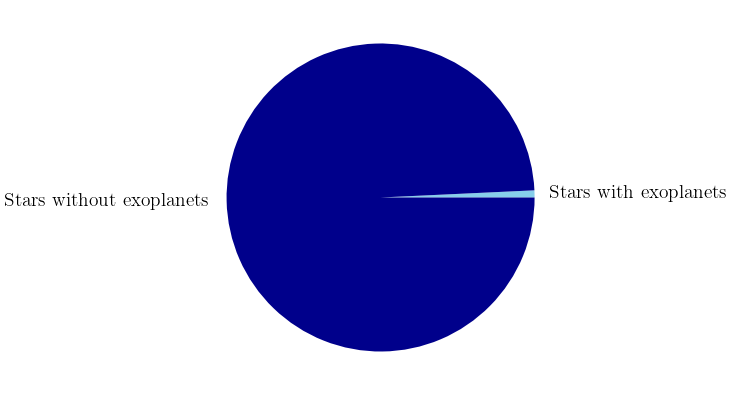

In [112]:
num_exo: int = len(index_exoplanet)
num_no_exo: int = len(index_no_exoplanet)
total: int = num_exo + num_no_exo

print('Number of stars with exoplanets: ', num_no_exo)
print(f'Number of stars without exoplanets: {num_exo} (= {num_exo / total * 100:.3f} %)')

# Define colors for the pie chart
colors: list[str] = ['skyblue', 'darkblue']

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Create the pie chart with the defined colors
patches, texts = ax.pie([num_exo, num_no_exo], labels=['Stars with exoplanets', 'Stars without exoplanets'], colors=colors)


# Improve the visibility of the labels by increasing their size
for text in texts:
    text.set_fontsize(14)

plt.show()

# B - Data Preprocessing
Data preprocessing is an essential step to train our machine learning model effectively. Preprocessing includes the filtering of NaN-data and outliers, the normalization and standardization of the data and the handling of the imbalanced dataset.

# B.1 - Filtering NaN-data and outliers

We see that the dataset contains no NaN value. The outliers were identified by computing the z-score over all flux rows. Computing means and standard-deviations aggregated over all rows, will lead to the problem that the relatively constant fluxes of stars with no exoplanets will severely be affected by stars with exoplanets, having fluctuations in the fluxes. Hence, standard scaling is done for each row separately. Rows with any value greater than three times the standard deviation were removed. Hence, in total 37 rows were removed by z-score filtering.


Number of rows before filtering NaN-data: 5657


C:\Users\nilse\AppData\Local\Temp\ipykernel_58824\3457803985.py:143: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  self.data.iloc[:, 3:] = self.data.drop(columns=no_vals).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1)


NaN-data filtered: 	 0 rows removed.


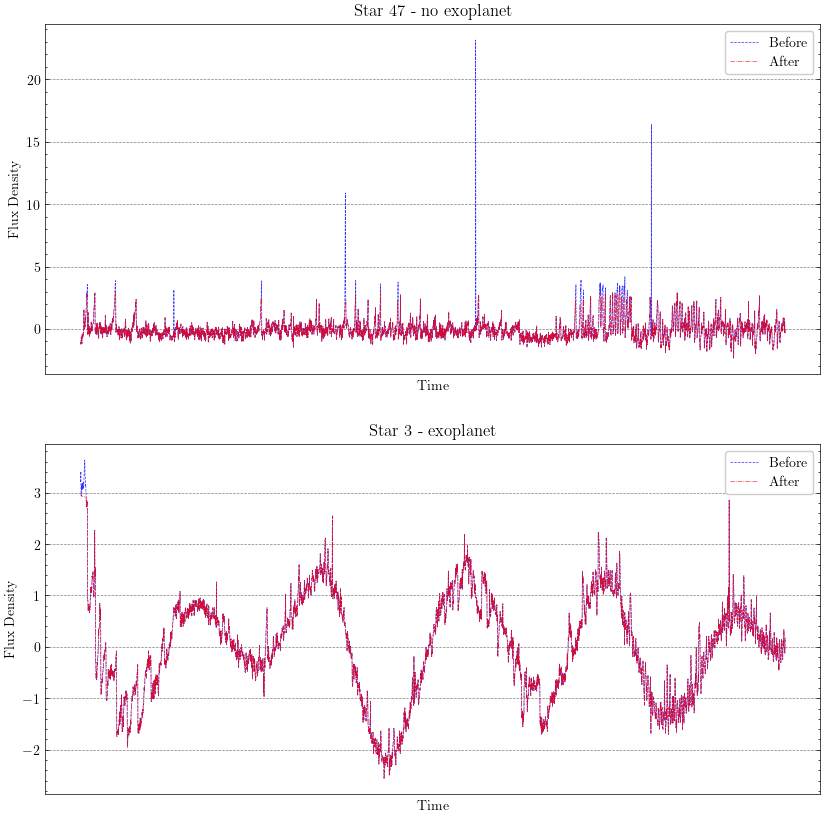

In [113]:
print(f"Number of rows before filtering NaN-data: {len(Kepler.data)}")

# Filter outliers
Kepler.scaler()

before_interpolation = Kepler.data.loc[test_stars]

Kepler.interpolate(threshold=3.)

# Filter NaN-data
Kepler.filter_nan()

# Plot the interpolated data
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for i in range(len(test_stars)):
    has_exoplanet = "no exoplanet" if Kepler.data.loc[test_stars[i]]['LABEL'] == 0 else "exoplanet"
    ax[i].plot(before_interpolation.iloc[i, 3:].to_numpy(), label='Before', linestyle='--', linewidth=0.5, alpha=0.8, color='blue')
    ax[i].plot(Kepler.data.loc[test_stars[i]][3:].to_numpy(), label='After', linestyle='-.', linewidth=0.5, alpha=0.8, color='red')
    ax[i].set_title(f"Star {test_stars[i]} - " + has_exoplanet)
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Flux Density")
    ax[i].set_xticks([])
    ax[i].legend()
plt.show()


## B.2 - Data Augmendataion
While we filtered the outliers, we also normalized the data, by subtracting the mean and dividing by the standard deviation. We can see the results of the normalization in the table below. Furthermore, we will use data augmentation techniques to generate more samples of stars with exoplanets. We will use time-shift augmentation, which shifts the light curves of stars with exoplanets by a certain number of time steps. This will create new samples of stars with exoplanets, which will help the model to learn the features of stars with exoplanets. Then we apply Gaussian noise as well as Gaussian filtering to the data. This will help the model to learn the features of stars with exoplanets and improve the generalization of the model.

In [114]:
#Kepler.data.describe()

### B.2.1 - Gaussian Filtering

As we could see, e.g. in A.3, the light curves of the stars are noisy. To reduce the effect of noise and smooth the light curves, to make general trends more visible, the application of a Gaussian filter may be beneficial as proposed in [Kyle A. Pearson, Leon Palafox and Caitlin A. Griffith, Searching for exoplanets using artificial intelligence, Monthly Notices of the Royal Astronomical Society, Volume 474, Issue 1, February 2018, Pages 478–491](https://doi.org/10.1093/mnras/stx2801). 
In the example below we see, indeed, that the Gaussian filter with \( \sigma = 1 \) smooths the light curves of the stars. 
The "data_augmented" DataFrame helps us to keep track of the original star-id and the new star-id after the augmentation.

In [115]:
augmented_idx: list[int] = Kepler.data[(Kepler.data['LABEL'] == 1) & (Kepler.data['TYPE'] == 'TRAIN')].sample(10, random_state=42).index

Kepler.gaussian_filter(ids=augmented_idx, sigma=1)

Kepler.data_augmented[Kepler.data_augmented['GAUSSIAN_FILTER'].notna()].astype('int64')

Input indices:  Index([17, 13, 4, 29, 35, 25, 6, 26, 24, 16], dtype='int64', name='ID')
Gaussian filter applied to stars: Index([5657, 5658, 5659, 5660, 5661, 5662, 5663, 5664, 5665, 5666], dtype='int32')


,GAUSSIAN_FILTER
ID,
4,5659
6,5663
13,5658
16,5666
17,5657
24,5665
25,5662
26,5664
29,5660


We verify the effect of the Gaussian filter by comparing the light curve of star 2 with its augmented version. We can see that the Gaussian filter smooths the light curve of the star and reduces the noise.

Original star: 6
Augmented star: 5663.0


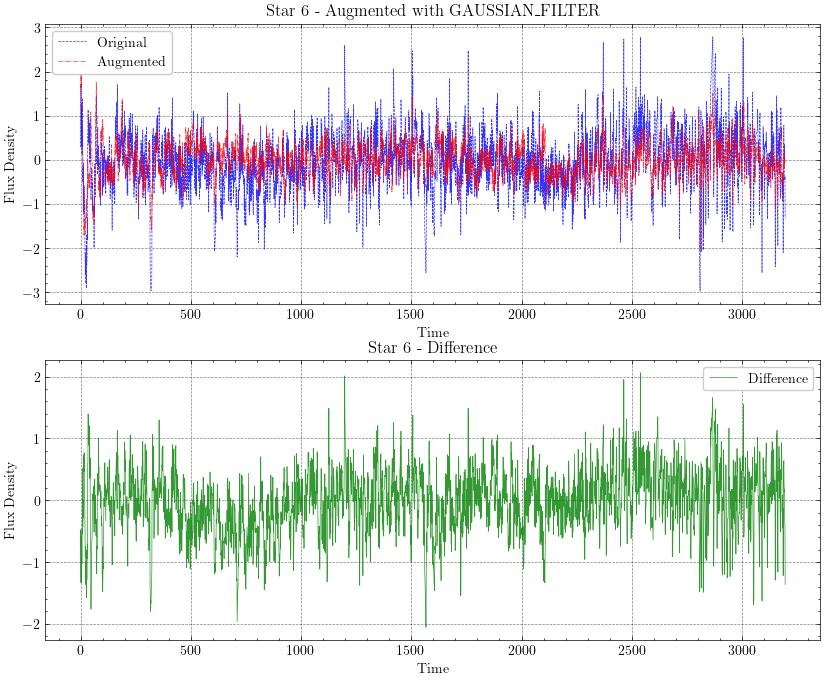

In [116]:
Kepler.compare_augmented(6, 'GAUSSIAN_FILTER')

### B.2.2 - Gaussian Noise
We can also turn the previous process around and add some noise to the data. This will help the model to learn the features of stars with exoplanets and improve the generalization of the model. In the example below, we apply Gaussian noise to the data and generate 10 new samples of stars with exoplanets.

Input indices:  Index([17, 13, 4, 29, 35, 25, 6, 26, 24, 16], dtype='int64', name='ID')
Gaussian noise applied to stars: Index([5667, 5668, 5669, 5670, 5671, 5672, 5673, 5674, 5675, 5676], dtype='int32')
Original star: 6
Augmented star: 5673.0


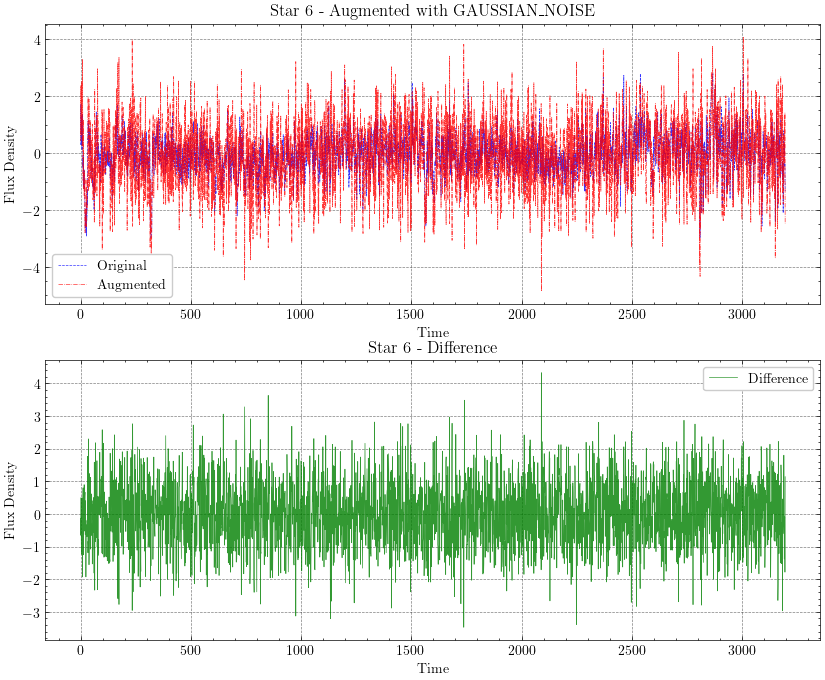

In [117]:
Kepler.gaussian_noise(ids=augmented_idx, sigma=1)
Kepler.compare_augmented(6, 'GAUSSIAN_NOISE')

### B.2.3 - Time-flip Augmentation
Another data augmentation technique is time-flip augmentation, which flips the light curves of stars with exoplanets. This will create new samples of stars with exoplanets, which will help the model to learn the features of stars with exoplanets.

Input indices:  Index([17, 13, 4, 29, 35, 25, 6, 26, 24, 16], dtype='int64', name='ID')
Time-flip augmentation applied to stars: Index([5677, 5678, 5679, 5680, 5681, 5682, 5683, 5684, 5685, 5686], dtype='int32')
Original star: 17
Augmented star: 5677.0


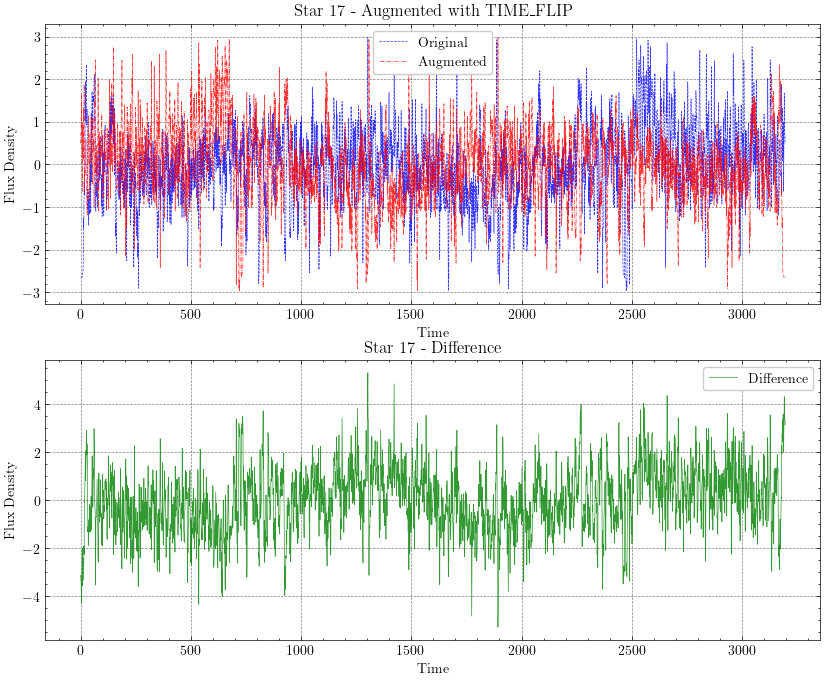

In [118]:
Kepler.time_flip(ids=augmented_idx)
Kepler.compare_augmented(17, 'TIME_FLIP')
#Kepler.data_augmented

## B.5 - Principal Component Analysis (PCA)
A main problem when handling data in high-dimensional space is the curse of dimensionality. The curse of dimensionality refers to the fact that the volume of the space increases exponentially with the number of dimensions. This leads to a sparsity of data points, which makes it difficult to learn the underlying structure of the data. To reduce the dimensionality of the data, we can apply Principal Component Analysis (PCA). PCA is a technique that transforms the data into a new coordinate system, where the new axes are the principal components of the data. The principal components are the eigenvectors of the covariance matrix of the data. The eigenvectors are sorted by their corresponding eigenvalues, which represent the variance of the data along the principal components. By selecting the first \( n \) principal components, we can reduce the dimensionality of the data to \( n \) dimensions, while retaining most of the variance of the data. In the example below, we apply PCA to the data and reduce the dimensionality to \( n \) dimensions, which explain 90% of the variance of the data.

In [119]:
cumulative_variance = Kepler.pca(variance_threshold=0.9)
var_90 = np.argmax(cumulative_variance >= 0.9) + 1

Kepler.data_pca.head()

Number of components to explain 90.0% of the variance: 669


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC663,PC664,PC665,PC666,PC667,PC668,PC669,LABEL,TYPE,FLAG
0,6.667197,3.005998,19.817530,-4.621478,-7.518772,-8.942460,2.179630,-4.239781,-4.445810,5.774278,...,-0.686565,-0.329565,0.549517,-0.154841,0.691233,-0.320977,-0.223349,1,TRAIN,False
1,-0.331521,-10.818165,0.968926,4.592764,-1.295064,-0.525757,3.710081,-1.825697,-2.995321,-0.440443,...,-0.138830,-0.788841,0.256737,0.721999,0.611252,0.139700,0.811110,1,TRAIN,False
2,14.154604,-19.233460,-2.431396,-17.902480,14.192459,-16.610829,-4.856880,6.031350,-3.228421,7.857133,...,0.944966,0.268668,0.187020,0.076751,0.680775,-0.456014,0.027081,1,TRAIN,False
3,0.880106,-10.342502,-10.221726,-27.143298,3.132147,-9.108109,10.345912,-14.055626,-1.250355,-3.129293,...,-0.158626,0.097717,-0.059252,0.391853,0.347767,0.067573,-0.144538,1,TRAIN,False
4,-5.335731,4.887643,0.687233,19.319703,-6.271544,1.724443,-4.878477,-13.393665,-4.908487,23.043277,...,0.584744,0.197728,-0.145023,0.071793,-0.774843,0.599679,0.303862,1,TRAIN,False


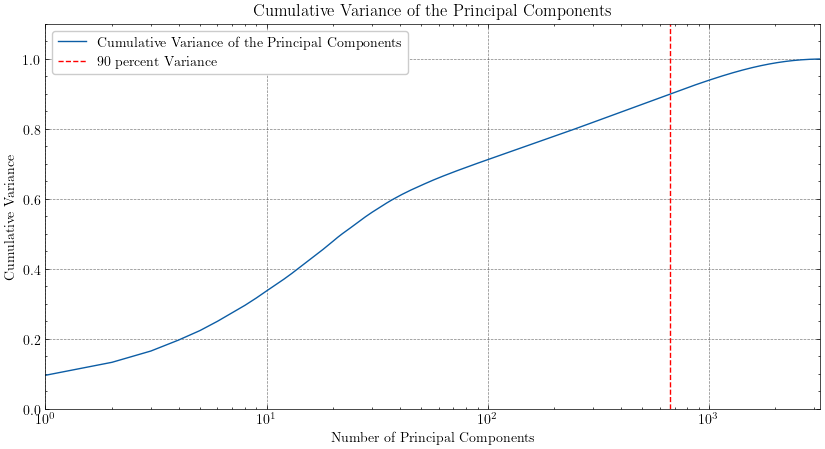

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(cumulative_variance, label='Cumulative Variance of the Principal Components')
ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Variance')
ax.set_xscale('log')
ax.set_xlim(1, len(cumulative_variance))
ax.set_ylim(0,1.1)
ax.vlines(var_90, 0, 1.1, color='red', linestyle='--', label=r'90 percent Variance')
ax.legend()
ax.set_title('Cumulative Variance of the Principal Components')
plt.show()

# C - Convolutional Neural Network
In this section we will setup a Convolutional Neural Network (CNN) using tensorflow and keras to classify the light transit curves of stars into two classes: stars with exoplanets and stars without exoplanets. We will train the CNN on the preprocessed data and evaluate its performance on the test data.

## C.1 - Model Setup
First we will use only not augmented data to train the model. We will then evaluate different models and compare their performance. We will then try to improve best model by using PCA-transformed data and then augmented data.

### C.1.1 - Model 1 (CONV(16, 5) - MAXPOOL - CONV(16, 5) - MAXPOOL - CONV(32, 5) - MAXPOOL - FLATTEN - DENSE(512) - DENSE(1))
We will begin with a setup as proposed in [Megan Ansdell, Yani Ioannou, Hugh P. Osborn, Michele Sasdelli, Scientific Domain Knowledge Improves Exoplanet Transit Classification with Deep Learning,The Astrophysical Journal Letters, Volume 869, Mumber 1, 2018](https://iopscience.iop.org/article/10.3847/2041-8213/aaf23b). While their approach consists of a global and a local view of the light curves, as an exoplanet transits, we will only consider the global view for now. 

In [121]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, GlobalMaxPooling1D
model = Sequential([
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=1, activation='sigmoid')])

Kepler.define_model(model)
Kepler.train_model(use_augmented=False)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.9468 - loss: 0.1783 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9900 - loss: 0.0596 - val_accuracy: 1.0000 - val_loss: 0.0153
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9893 - loss: 0.0565 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9911 - loss: 0.0516 - val_accuracy: 1.0000 - val_loss: 0.0136
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9899 - loss: 0.0510 - val_accuracy: 1.0000 - val_loss: 0.0042
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9923 - loss: 0.0421 - val_accuracy: 1.0000 - val_loss: 0.0081
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9930 - loss: 0.0373 - val_accuracy: 1.0000 - val_loss: 0.0141
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9903 - loss: 0.0474 - val_accu

#### Loss Function
The loss function indicates that 10 epochs are sufficient to train the model. We can see that the loss decreases over the epochs, which indicates that the model is learning the features of the data.

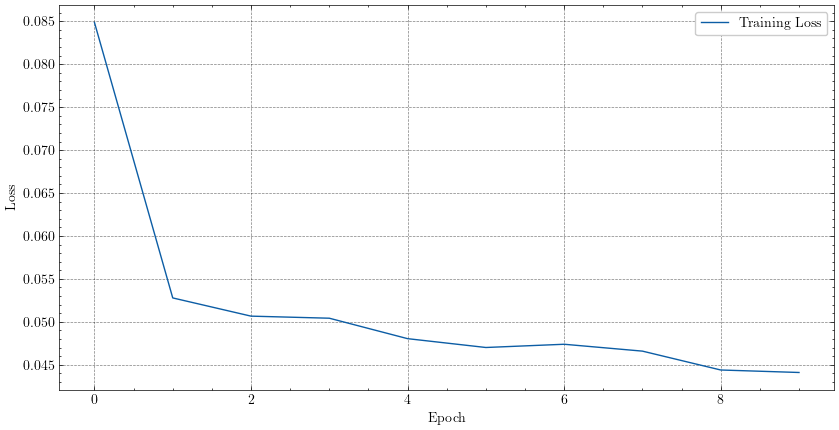

In [122]:
Kepler.plot_loss()

#### Results
All stars without exoplanets are correctly classified. However, no star with an exoplanet is classified correctly. 

In [123]:
Kepler.test_model()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       1.00      0.50      0.50       570
weighted avg       0.99      0.99      0.99       570



{'accuracy': 0.9912280701754386,
 'precision': 1.0,
 'recall': 0.0,
 'f1_score': 0.0}

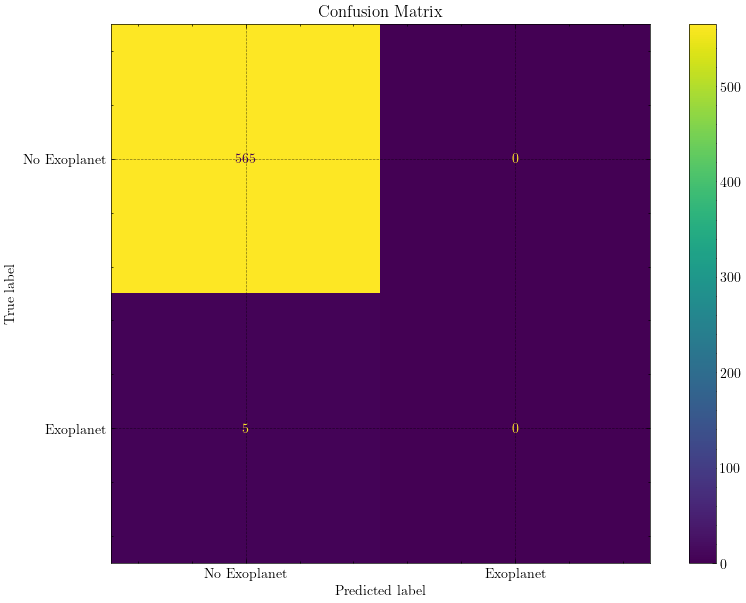

In [124]:
Kepler.plot_confusion_matrix()

### C.1.2 - Model 2 (CONV(32, 3) - MAXPOOL - CONV(64, 3) - MAXPOOL - CONV(128, 3) - MAXPOOL - FLATTEN - DENSE(128) - DENSE(1))
We will now try to improve the model by increasing the number of filters in the convolutional layers and the number of units in the dense layer.

In [125]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

Kepler.define_model(model)
Kepler.train_model(use_augmented=False)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9708 - loss: 0.1118 - val_accuracy: 1.0000 - val_loss: 8.8797e-04
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.9908 - loss: 0.0394 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9977 - loss: 0.0084 - val_accuracy: 1.0000 - val_loss: 5.8666e-04
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.9980 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 2.6385e-04
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9990 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 5.4508e-05
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.9997 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 4.5956e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9998 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 5.3524e-04
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 

#### Loss Function

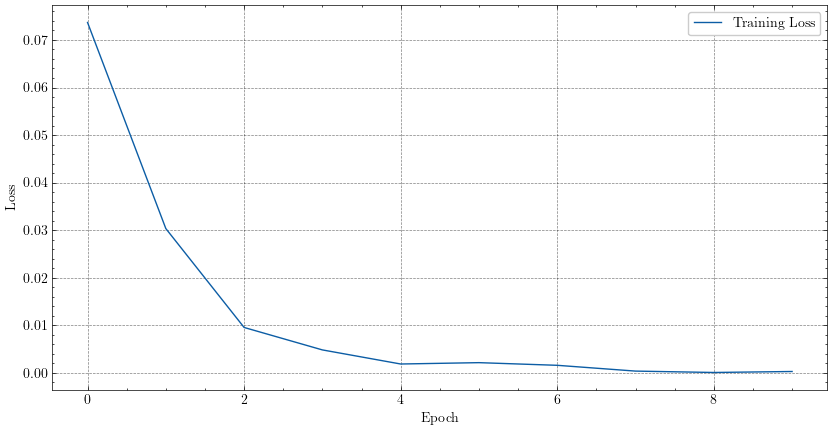

In [126]:
Kepler.plot_loss()

#### Results
Again, all stars without exoplanets are correctly classified. However, no star with an exoplanet is classified correctly.

In [127]:
Kepler.test_model()

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.40      0.57         5

    accuracy                           0.99       570
   macro avg       1.00      0.70      0.78       570
weighted avg       0.99      0.99      0.99       570



{'accuracy': 0.9947368421052631,
 'precision': 1.0,
 'recall': 0.4,
 'f1_score': 0.5714285714285714}

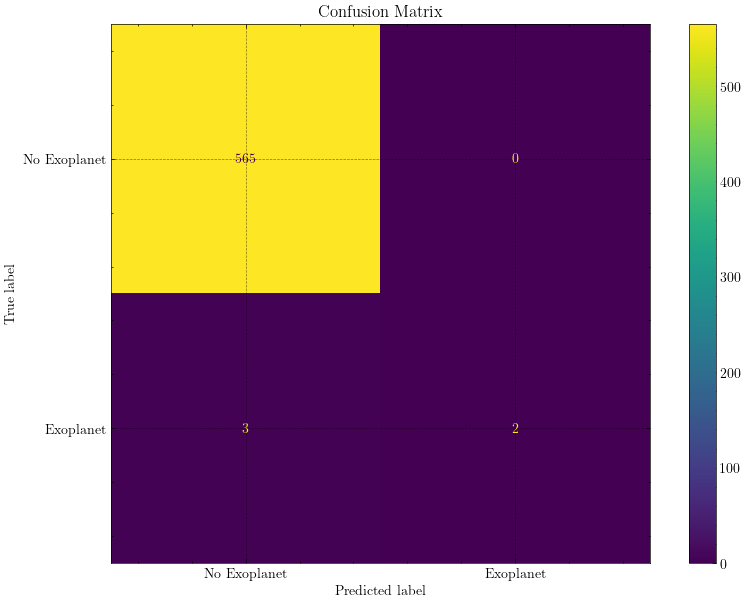

In [128]:
Kepler.plot_confusion_matrix()

### C.1.3 - Model 3 (CONV(32, 3) - MAXPOOL - CONV(64, 3) - MAXPOOL - CONV(128, 3) - MAXPOOL - FLATTEN - DENSE(256) - DENSE(1))
We will now try to improve the model by increasing the number of units in the dense layer.

In [129]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

Kepler.define_model(model)
Kepler.train_model(use_augmented=False)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.9499 - loss: 0.1716 - val_accuracy: 1.0000 - val_loss: 0.0097
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9922 - loss: 0.0308 - val_accuracy: 1.0000 - val_loss: 3.0215e-04
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9985 - loss: 0.0075 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9995 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 3.8217e-04
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.9995 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 6.9743e-04
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9998 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 6.2675e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9990 - loss: 0.0049 - val_accuracy: 1.0000 - val_loss: 1.0139e-04
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.

#### Results
This model performs better: 2 out of 5 exoplanets are correctly classified.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



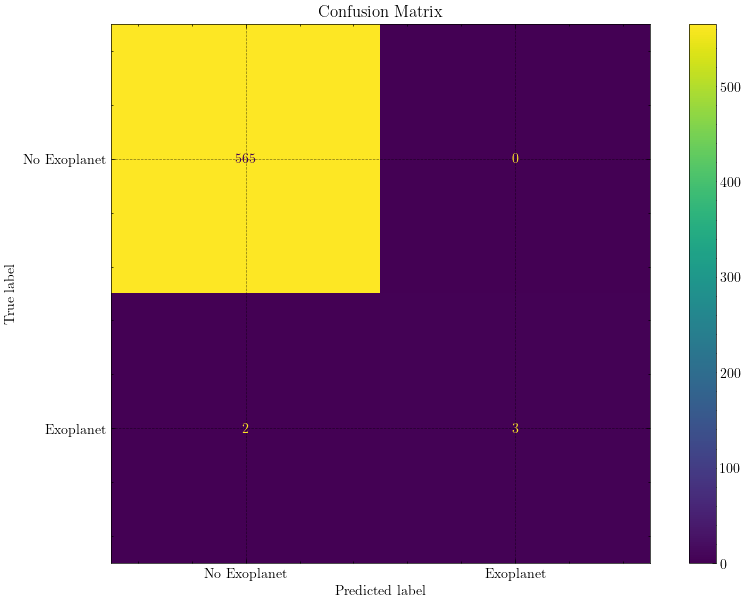

In [130]:
Kepler.test_model()
Kepler.plot_confusion_matrix()

### C.1.4 - Model 4 (CONV(32, 3) - MAXPOOL - CONV(64, 3) - MAXPOOL - CONV(128, 3) - MAXPOOL - FLATTEN - DENSE(256) - DENSE(1)) - With PCA
We see that the last model performs best. We now try to improve the model by using the PCA-transformed data.

In [131]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

Kepler.define_model(model)
Kepler.train_model(which='pca', use_augmented=False)


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9537 - loss: 0.1075 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.9936 - loss: 0.0382 - val_accuracy: 1.0000 - val_loss: 0.0074
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9911 - loss: 0.0346 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9919 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9913 - loss: 0.0143 - val_accuracy: 1.0000 - val_loss: 0.0041
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9936 - loss: 0.0079 - val_accuracy: 1.0000 - val_loss: 6.2166e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9966 - loss: 0.0055 - val_accuracy: 1.0000 - val_loss: 0.0019
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9952 - loss: 0.0060 - val_

#### Results
Well - we see that the model does **not** perform better with the PCA-transformed data. PCA is in many cases a good way to prevent overfitting, by computing the principal components of the data. Yet, the flux densities of stars having exoplanets does actually not depend on the time. Hence, applying a PCA probably removes important information from the data.

In [132]:
Kepler.test_model(which='pca')

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.00      0.00         5

    accuracy                           0.99       570
   macro avg       1.00      0.50      0.50       570
weighted avg       0.99      0.99      0.99       570



{'accuracy': 0.9912280701754386,
 'precision': 1.0,
 'recall': 0.0,
 'f1_score': 0.0}

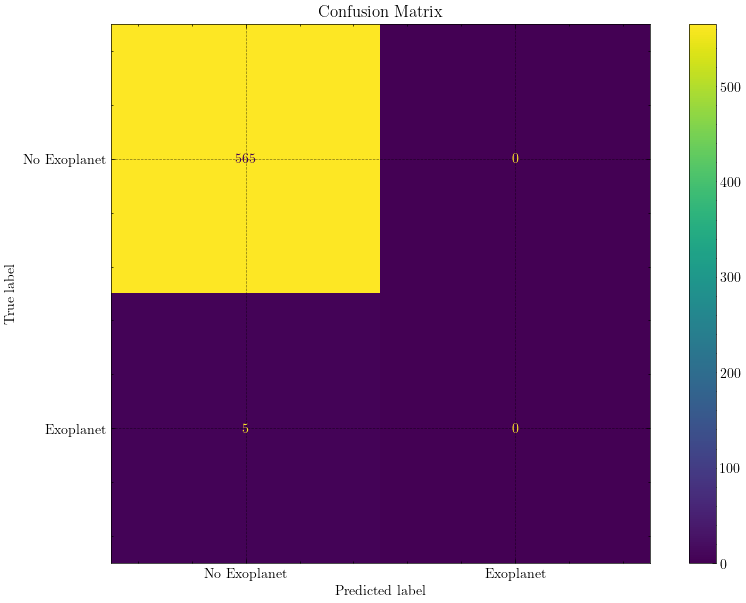

In [133]:
Kepler.plot_confusion_matrix()

### C.1.5 - Model 5 (CONV(32, 3) - MAXPOOL - CONV(64, 3) - MAXPOOL - CONV(128, 3) - MAXPOOL - FLATTEN - DENSE(256) - DENSE(1)) - With Augmented Data
Finally, we will try to improve the model by using the augmented data.

In [134]:
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

Kepler.define_model(model)
Kepler.train_model(use_augmented=True)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - accuracy: 0.9636 - loss: 0.1760 - val_accuracy: 0.9707 - val_loss: 0.1803
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9914 - loss: 0.0381 - val_accuracy: 0.9805 - val_loss: 0.1502
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9961 - loss: 0.0126 - val_accuracy: 0.9805 - val_loss: 0.0976
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9805 - val_loss: 0.2394
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.9998 - loss: 7.7174e-04 - val_accuracy: 0.9824 - val_loss: 0.1011
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.9994 - loss: 0.0015 - val_accuracy: 0.9805 - val_loss: 0.3483
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 102ms/step - accuracy: 0.9998 - loss: 7.0480e-04 - val_accuracy: 0.9805 - val_loss: 0.2573
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - accuracy: 1.0000 - l

#### Results
The model performs best with the augmented data. 4 out of 5 exoplanets are correctly classified.

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       565
           1       1.00      0.60      0.75         5

    accuracy                           1.00       570
   macro avg       1.00      0.80      0.87       570
weighted avg       1.00      1.00      1.00       570



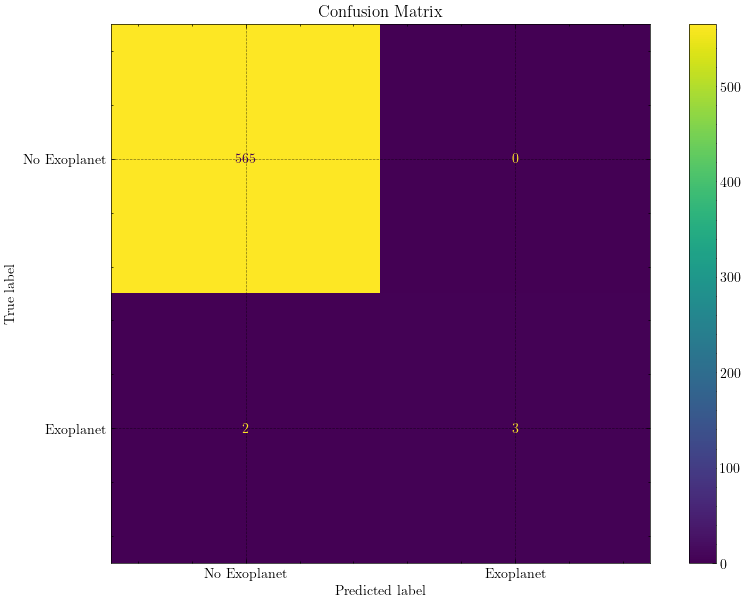

In [135]:
Kepler.test_model()
Kepler.plot_confusion_matrix()

In [142]:
model = Sequential([
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5, strides=2),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5, strides=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5, strides=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=5, strides=2),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    #Dense(units=128, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

Kepler.define_model(model)
Kepler.train_model(use_augmented=True)

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.9597 - loss: 0.1109 - val_accuracy: 0.9707 - val_loss: 0.2317
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.9886 - loss: 0.0598 - val_accuracy: 0.9707 - val_loss: 0.1606
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - accuracy: 0.9911 - loss: 0.0397 - val_accuracy: 0.9834 - val_loss: 0.0705
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.9944 - loss: 0.0271 - val_accuracy: 0.9824 - val_loss: 0.1031
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - accuracy: 0.9968 - loss: 0.0115 - val_accuracy: 0.9785 - val_loss: 0.1184
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9979 - loss: 0.0103 - val_accuracy: 0.9805 - val_loss: 0.1849
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9982 - loss: 0.0063 - val_accuracy: 0.9814 - val_loss: 0.2477
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.9976 - loss: 0.0064 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       565
           1       1.00      0.40      0.57         5

    accuracy                           0.99       570
   macro avg       1.00      0.70      0.78       570
weighted avg       0.99      0.99      0.99       570



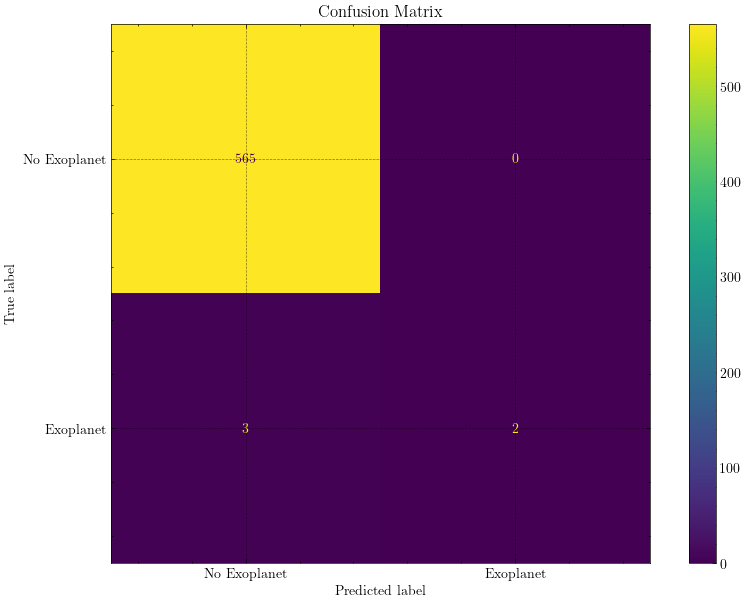

In [141]:
Kepler.test_model()
Kepler.plot_confusion_matrix()